# **This notebook aims to study interpretability methods for Gradient Boosting Survival ML**

In [66]:
# Bibliothèques pour les calculs, tableaux et tracé de fonctions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bibliothèque pour l'implémentation demodèles de ML
import xgboost as xgb
import sklearn as skl
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from lifelines import CoxPHFitter
import optuna
import shap
from itertools import product


# Survival Analysis tools
import sksurv
#import survlimepy
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.datasets import get_x_y
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, cumulative_dynamic_auc, integrated_brier_score
from sksurv.metrics import as_concordance_index_ipcw_scorer, as_cumulative_dynamic_auc_scorer, as_integrated_brier_score_scorer
#from survlimepy import SurvLimeExplainer

# **Read and processing**

In [27]:
data_rea = pd.read_csv("readmission.csv")
data_rea.head()

id  enum  t.start  t.stop  time  event       chemo     sex dukes charlson  \
0   1     1        0      24    24      1     Treated  Female     D        3   
1   1     2       24     457   433      1     Treated  Female     D        0   
2   1     3      457    1037   580      0     Treated  Female     D        0   
3   2     1        0     489   489      1  NonTreated    Male     C        0   
4   2     2      489    1182   693      0  NonTreated    Male     C        0   

   death  
0      0  
1      0  
2      0  
3      0  
4      0

In [28]:
# Keep only the last admission for each patient
rea_sorted = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtred = rea_sorted.groupby('id').last().reset_index()

rea_filtred.head()

id  enum  t.start  t.stop  time  event       chemo     sex dukes charlson  \
0   1     3      457    1037   580      0     Treated  Female     D        0   
1   2     2      489    1182   693      0  NonTreated    Male     C        0   
2   3     2       15     783   768      0  NonTreated    Male     C        3   
3   4     5      686    2048  1362      0     Treated  Female   A-B        0   
4   5     2     1134    1144    10      0  NonTreated  Female     C        3   

   death  
0      0  
1      0  
2      1  
3      0  
4      0

In [29]:
# One-hot encoding
categorial_columns = ['sex', 'chemo', 'dukes', 'charlson']
encoder = OneHotEncoder()
encoder.fit(rea_filtred[categorial_columns])
rea_encoded = encoder.fit_transform(rea_filtred[categorial_columns]).toarray()
new_column_names = encoder.get_feature_names_out(categorial_columns)
rea_encoded_df = pd.DataFrame(rea_encoded, columns=new_column_names)

# remove useless columns
rea_final = rea_filtred.drop(columns=categorial_columns).join(rea_encoded_df).drop(columns=['id', 't.start', 't.stop', 'event'])

rea_final.head()

enum  time  death  sex_Female  sex_Male  chemo_NonTreated  chemo_Treated  \
0     3   580      0         1.0       0.0               0.0            1.0   
1     2   693      0         0.0       1.0               1.0            0.0   
2     2   768      1         0.0       1.0               1.0            0.0   
3     5  1362      0         1.0       0.0               0.0            1.0   
4     2    10      0         1.0       0.0               1.0            0.0   

   dukes_A-B  dukes_C  dukes_D  charlson_0  charlson_1-2  charlson_3  
0        0.0      0.0      1.0         1.0           0.0         0.0  
1        0.0      1.0      0.0         1.0           0.0         0.0  
2        0.0      1.0      0.0         0.0           0.0         1.0  
3        1.0      0.0      0.0         1.0           0.0         0.0  
4        0.0      1.0      0.0         0.0           0.0         1.0

In [30]:
# Data split

X,y = get_x_y(rea_final,attr_labels=['death','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# **Cox model**

In [31]:
# Create Cox model
cox_model = CoxPHFitter()

# Fit the model, for each categorical feature we drop the last category to avoid multicollinearity
cox_model.fit(rea_final.drop(columns=['sex_Male','chemo_Treated','dukes_D','charlson_3']), duration_col='time', event_col='death')

# Display the summary of the model
print(cox_model.summary)

                      coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                         
enum              0.105836   1.111639  0.027017        0.052883   
sex_Female       -0.317669   0.727844  0.202241       -0.714054   
chemo_NonTreated -0.312487   0.731625  0.222345       -0.748276   
dukes_A-B        -2.312249   0.099038  0.349264       -2.996793   
dukes_C          -1.307589   0.270471  0.253114       -1.803684   
charlson_0       -1.194696   0.302796  0.233451       -1.652252   
charlson_1-2     -0.556968   0.572944  0.630153       -1.792046   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                    
enum                    0.158788             1.054306             1.172090   
sex_Female              0.078717             0.489655             1.081898   
chemo_NonTreated        0.123301             0.473182             1.131225   
dukes_

# **Survival Gradient Boosting**

In [32]:
# Create and fit the survival gradient boosting

sgb = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)
sgb.fit(X_train, y_train)
cindex = sgb.score(X_test, y_test)
print(round(cindex, 3))

0.872


In [33]:
# define the concordance index

def concordance_censored(estimator,X,y):
    concordance = concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))
    return concordance[0]

print(f"c_index : {concordance_censored(sgb,X_test,y_test)}")

# define the concordance index ipcw

concordance_ipcw = concordance_index_ipcw(y_train,y_test,sgb.predict(X_test))
print(f"c_index_ipcw : {concordance_ipcw[0]}")

# compute the auc dynamic score

auc_dynamic = cumulative_dynamic_auc(y_train,y_test,sgb.predict(X_test),times = np.arange(1, 1945, 30))
print(f"auc_dynamic : {auc_dynamic[1]}")

c_index : 0.8721934369602763
c_index_ipcw : 0.8610552963958166
auc_dynamic : 0.9084090769373823


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


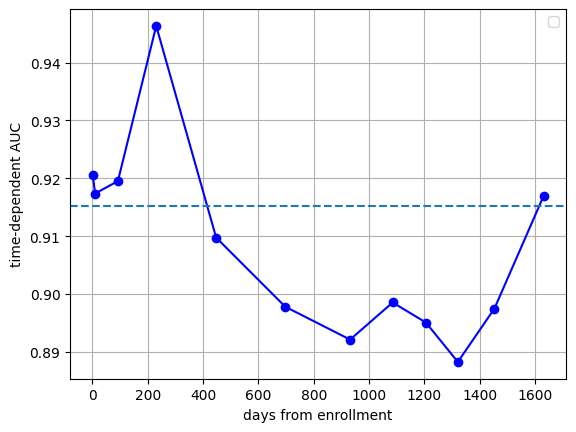

In [74]:
times = np.percentile(rea_final['time'], np.linspace(15, 90, 12))
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, sgb.predict(X_test), times = times)
plt.plot(times, auc, marker="o", color='blue')
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.axhline(mean_auc, linestyle="--")
plt.legend()
plt.grid()

## Hyperparameters optimization

In [34]:
# Hyperparameters optimization with optuna

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance

def objective(trial):
    # Define search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }
    
    # Initialize model with hyperparameters
    model = GradientBoostingSurvivalAnalysis(**params)
    
    def k_fold_cross_validation(model, X, y, k=5):
        """
        Performs k-fold cross-validation for a given model and dataset.

        Parameters:
            model: The machine learning model to evaluate.
            X (numpy.ndarray): The feature matrix.
            y (numpy.ndarray): The target vector.
            k (int): Number of folds for cross-validation.

        Returns:
            float: The average accuracy across all folds.
        """
        n = len(X)
        fold_size = n // k
        scores = []

        for i in range(k):
            # Splitting data into training and validation sets
            validation_X = X[i * fold_size: (i + 1) * fold_size]
            validation_y = y[i * fold_size: (i + 1) * fold_size]
            train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
            train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

            # Fitting the model
            model.fit(train_X, train_y)

            # Making predictions on the validation set
            y_pred = model.predict(validation_X)

            # Calculating accuracy
            score = scorer(model, validation_X, validation_y)
            scores.append(score)

        # Returning the average accuracy
        return sum(scores) / k
    
    return k_fold_cross_validation(model, X_train, y_train, k=5)

# Create Optuna study object
study = optuna.create_study(direction='maximize')

# Run optimization
study.optimize(objective, n_trials=50)

# Access best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-18 10:15:22,445] A new study created in memory with name: no-name-20a7f57b-ba6f-4ee2-8183-ec7c920b1ff4
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Loc

Best Hyperparameters: {'n_estimators': 116, 'learning_rate': 0.08250350043898853, 'subsample': 0.6863594076347115, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_depth': 5}


In [35]:
# Hyperparameters optimization with a gridsearch approach, we use a gridsearch suggested by the optuna optimization

# Define the gridsearch space
param_grid = {'n_estimators': [231, 232, 233, 234, 235],
              'learning_rate': [0.051, 0.054, 0.06, 0.05774248],
              'subsample': [0.62,0.631222,0.64],
              'max_depth': [3, 4, 2],
              'min_samples_split': [19, 20, 21],
              'min_samples_leaf': [11, 12, 13]}

param_comb = list(product(*(param_grid[param] for param in param_grid.keys())))

# We use the concordance index as evaluation metric
def scorer(estimator, X, y):
    concordance =  concordance_index_censored([elt[0] for elt in y],[elt[1] for elt in y],estimator.predict(X))[0]
    return concordance

# Initialize the model
best_score = 0
best_params = None

for comb in param_comb : 
    # Create model instance with current hyperparameters
    model = GradientBoostingSurvivalAnalysis(n_estimators=comb[0], learning_rate=comb[1], subsample=comb[2], max_depth=comb[3], min_samples_split = comb[4], min_samples_leaf = comb[5], random_state = 42)
    
    def k_fold_cross_validation(model, X, y, k=5):
        """
        Performs k-fold cross-validation for a given model and dataset.

        Parameters:
            model: The machine learning model to evaluate.
            X (numpy.ndarray): The feature matrix.
            y (numpy.ndarray): The target vector.
            k (int): Number of folds for cross-validation.

        Returns:
            float: The average accuracy across all folds.
        """
        n = len(X)
        fold_size = n // k
        scores = []

        for i in range(k):
            # Splitting data into training and validation sets
            validation_X = X[i * fold_size: (i + 1) * fold_size]
            validation_y = y[i * fold_size: (i + 1) * fold_size]
            train_X = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
            train_y = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

            # Fitting the model
            model.fit(train_X, train_y)

            # Making predictions on the validation set
            y_pred = model.predict(validation_X)

            # Calculating accuracy
            score = scorer(model, validation_X, validation_y)
            scores.append(score)
            
        # Returning the average accuracy
        return sum(scores) / k
    
    if k_fold_cross_validation(model, X_train, y_train, k=5)>best_score:
        best_score = k_fold_cross_validation(model, X_train, y_train, k=5)
        best_params = {'n_estimators':comb[0], 'learning_rate':comb[1], 'subsample':comb[2], 'max_depth':comb[3], 'min_samples_split' : comb[4], 'min_samples_leaf': comb[5], 'random_state' : 42}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but Gradient

Best Hyperparameters: {'n_estimators': 235, 'learning_rate': 0.051, 'subsample': 0.62, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 13, 'random_state': 42}
Best Score: 0.8707131160221337


c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(
c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


In [36]:
# Best GradientBoostingSurvivalAnalysis model

best_SGB = GradientBoostingSurvivalAnalysis(**best_params)
best_SGB.fit(X_train, y_train)

# Compute the concordance index

print(f"c_index : {concordance_censored(best_SGB,X_test,y_test)}")

c_index : 0.8881692573402418


## Optimising hyperparameters according to metrics

In [68]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}

In [75]:
gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(best_SGB, tau=times[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [77]:
gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(best_SGB, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

In [78]:
gcv_ibs = GridSearchCV(
    as_integrated_brier_score_scorer(best_SGB, times=times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

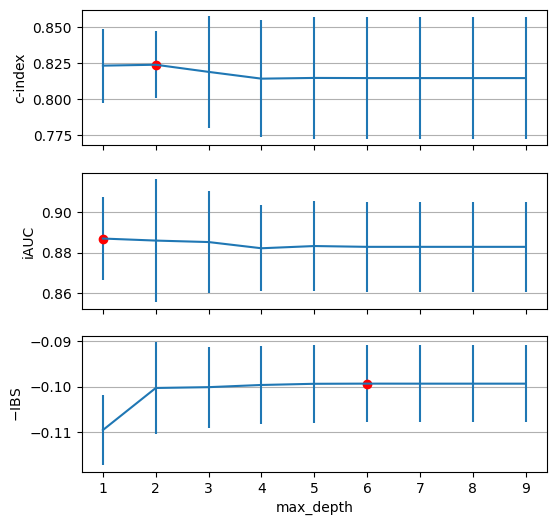

In [79]:
def plot_grid_search_results(gcv, ax, name):
    ax.errorbar(
        x=gcv.cv_results_["param_estimator__max_depth"].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["estimator__max_depth"],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)


_, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axs[-1].set_xlabel("max_depth")

plot_grid_search_results(gcv_cindex, axs[0], "c-index")
plot_grid_search_results(gcv_iauc, axs[1], "iAUC")
plot_grid_search_results(gcv_ibs, axs[2], "$-$IBS")

# **Interpretability methods**

# RVI

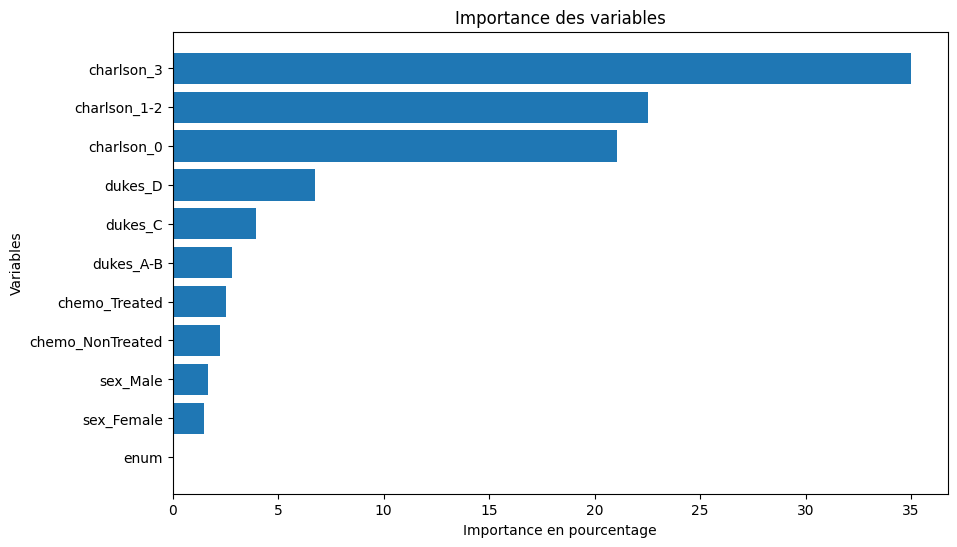

In [40]:
feature_importances = best_SGB.feature_importances_

total_importance = np.sum(feature_importances)
importances_percentage = (feature_importances / total_importance) * 100
importances_percentage.sort()
variable_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances_percentage)), importances_percentage, tick_label=variable_names)
plt.xlabel('Importance en pourcentage')
plt.ylabel('Variables')
plt.title('Importance des variables')
plt.show()

# LIME

In [81]:
explainer_gb = SurvLimeExplainer(
    training_features=X_train,
    training_events=[tp[0] for tp in y_train],
    training_times=[tp[1] for tp in y_train],
    model_output_times=best_SGB.event_times_,
    random_state=42,
)


NameError: name 'SurvLimeExplainer' is not defined

In [80]:
x_new = np.array([0.1,0.1])

b_gb = explainer_gb.explain_instance(
    data_row=x_new,
    predict_fn=best_SGB.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)

explainer_gb.plot_weights()

NameError: name 'explainer_gb' is not defined

# SHAP

In [54]:
# Let's use shap method to interpret this model, since the output of a SSVM is a risk score, we can use classical shap method to interpret it

# use Tree Explainer SHAP to explain test set predictions
explainer = shap.Explainer(best_SGB.predict, X_train)
shap_values = explainer.shap_values(X_test)

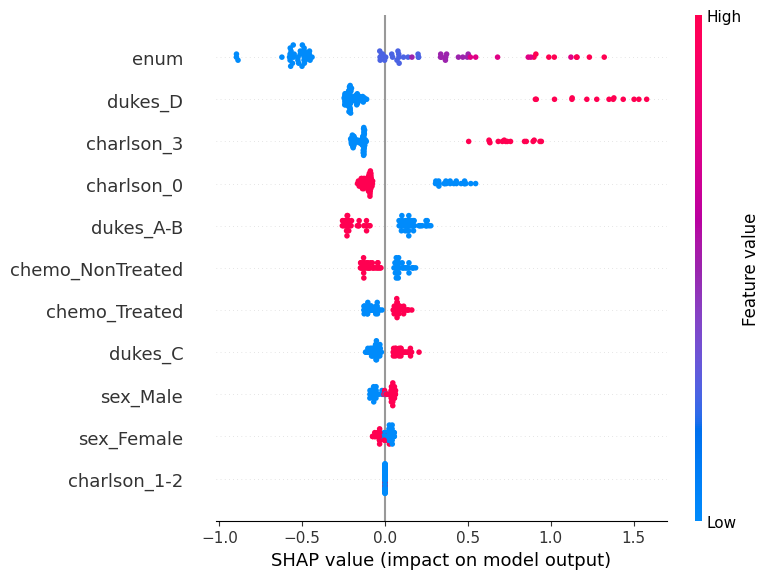

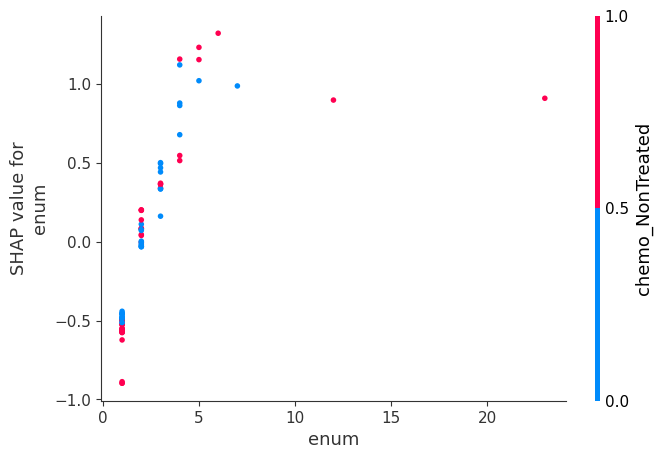

In [61]:
shap.summary_plot(shap_values,X_test)

shap.dependence_plot("enum", shap_values, X_test)

# Pipelines

## Pre-processing pipelines

In [67]:
class FeatureTypeSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
        return numeric_features, categorical_features
        

feature_type_selector = FeatureTypeSelector()
numeric_features = feature_type_selector.fit_transform(X)[0]
categorical_features = feature_type_selector.fit_transform(X)[1]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())     # useful for SVM
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])


preprocessor = FeatureUnion(transformer_list=[
    ('num', numeric_transformer, numeric_features),  
    ('cat', categorical_transformer, categorical_features)  
])


# Data pre-processing 
X_processed = preprocessor.fit_transform(X)

ValueError: too many values to unpack (expected 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
pipeline = Pipeline(steps=[
    ('SGB', GradientBoostingSurvivalAnalysis())  
])

model = pipeline.fit_transform(X_train,y_train)